In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.wcs as wcs
import pandas as pd
import scipy.io
from scipy.ndimage import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.wcs import WCS
from scipy.io import loadmat
from ciber_mocks import *

This notebook is meant to go through the basic steps of generating a density field using the lognormal model, and painting galaxies drawn from a luminosity function with potential redshift dependence. The code works using Python 3, though the only script that specifically needs Python 3 vs. Python 2 is `halo_model.py`(camb module).

In [7]:
# initialize the ciber_mock class object
cmock = ciber_mock(ciberdir='/Users/luminatech/Documents/ciber2/ciber/') # set pcat_model_eval default to False in updated code


In [8]:
def plot_map(image, figsize=(8,8), title=None, titlefontsize=16, xlabel='x [pix]', ylabel='y [pix]',\
             x0=None, x1=None, y0=None, y1=None, lopct=5, hipct=99,\
             return_fig=False, show=True, nanpct=True, cl2d=False, cmap='viridis', noxticks=False, noyticks=False):
    
    ''' 
    This is a convenience function for quickly looking at various maps to confirm they look okay
    
    '''
    f = plt.figure(figsize=figsize)
    if title is not None:
    
        plt.title(title, fontsize=titlefontsize)
    if nanpct:
        plt.imshow(image, vmin=np.nanpercentile(image, lopct), vmax=np.nanpercentile(image, hipct), cmap=cmap, origin='lower')
        print('min max of image in plot map are ', np.min(image), np.max(image))
    else:
        plt.imshow(image, cmap=cmap, origin='lower', interpolation='none')
    plt.colorbar(fraction=0.046, pad=0.04)
    if x0 is not None and x1 is not None:
        plt.xlim(x0, x1)
        plt.ylim(y0, y1)
        
    if cl2d:
        plt.xlabel('$\\ell_x$', fontsize=16)
        plt.ylabel('$\\ell_y$', fontsize=16)
    else:
        plt.xlabel(xlabel, fontsize=16)
        plt.ylabel(ylabel, fontsize=16)

    if noxticks:
        plt.xticks([], [])
    if noyticks:
        plt.yticks([], [])
        
    plt.tick_params(labelsize=14)

    if show:
        plt.show()
    if return_fig:
        return f
    
def save_mock_to_fits(full_maps, cats, tail_name, m_tracer_max=None, m_min=None, m_max=None, inst=None, \
                     data_path='/Users/luminatech/Documents/ciber2/ciber/data/mock_cib_fftest/082321/', \
                     ifield_list=None):
    ''' 
    This function is dedicated to converting mocks from ciber_mock.make_mock_ciber_map()
    to a fits file where they can be later accessed.
    '''
    hdul = []
    hdr = fits.Header()

    if m_tracer_max is not None:
        hdr['m_tracer_max'] = m_tracer_max
    if m_min is not None:
        hdr['m_min'] = m_min
    if m_max is not None:
        hdr['m_max'] = m_max
    if inst is not None:
        hdr['inst'] = inst
        
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdul.append(primary_hdu)

    for c, cat in enumerate(cats):
        tab = Table([cat[:,0], cat[:,1], cat[:,2], cat[:,3], cat[:,4], cat[:,5], cat[:,6]], names=('x', 'y', 'redshift', 'm_app', 'M_abs', 'Mh', 'Rvir'))
        cib_idx = c
        if ifield_list is not None:
            cib_idx = ifield_list[c]
            
        hdu = fits.BinTableHDU(tab, name='tracer_cat_'+str(cib_idx))
        hdul.append(hdu)

        im_hdu = fits.ImageHDU(full_maps[c], name='map'+str(cib_idx))
        hdul.append(im_hdu)


    hdulist = fits.HDUList(hdul)
            
    hdulist.writeto(data_path+tail_name+'.fits', overwrite=True)

The function `ciber_mock.make_mock_ciber_map()` is the wrapper function to generate a full mock catalog/CIBER image. If there is no mock catalog input, the function draws a galaxy catalog from the Helgason model with `generate_galaxy_catalogs()` the `galaxy_catalog` class. With a catalog in hand, the function then imposes any cuts on magnitude, computes mock source intensities and generates the corresponding maps used for the final CIBER mocks with `ciber_mock.mocks_from_catalogs()`.

In [7]:

# relevant if you want to save part of the catalog to construct an astronomical source mask with later
# these are in AB mag
m_tracer_max = 19 
m_min = 10
m_max = 26 

# band=0 == inst=1 == J-band
# band=1 == inst=2 == H-band
band=0
inst = band+1

# specify location to save data
datestr = '100921'
data_path= '/Volumes/Seagate Backup Plus Drive/Toolkit/Mirror/Richard/ciber_mocks/'+datestr+'/TM'+str(inst)+'/'

# this is the list of indices corresponding to the CIBER science fields
ifield_list = [4, 5, 6, 7, 8] 

# number of observation sets, where each "set" is 5 fields
simidx_range = np.arange(1)

for i in simidx_range:
    print('Generating simulation set '+str(i)+' of '+str(len(simidx_range))+'..')
    
    full_maps, _, _, cats =  cmock.make_mock_ciber_map(None, m_min, m_max, ifield_list=ifield_list, band=band, ncatalog=len(ifield_list), \
                                                            cat_return='tracer', m_tracer_max=m_tracer_max)
    
    plot_map(full_maps[0], title='CIB source map, ifield='+str(ifield_list[0]))

    # now that we have the catalogs and associated images, save using save_mock_to_fits()
    tail_name = 'cib_with_tracer_5field_set'+str(i)+'_'+datestr+'_TM'+str(inst)
#     save_mock_to_fits(full_maps, cats, tail_name, data_path=data_path, m_tracer_max=m_tracer_max, m_min=m_min, m_max=m_max,\
#                       inst=inst, ifield_list=ifield_list)
    
    
    

Generating simulation set 0 of 2..
helgason band is  J
midzs: [0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
dzs: [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
number counts has shape  (8, 200) while Mapps has nbins= 200


/usr/local/lib/python3.9/site-packages/astropy/cosmology/core.py:1447: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/hmf/density_field/halofit.py:106: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")
/Users/luminatech/Documents/ciber2/ciber/lognormal_counts.py:145: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ells))


number counts here are: 21896.0 4.0
number counts here are: 62636.0 4.0
number counts here are: 95448.0 4.0
number counts here are: 112192.0 4.0
number counts here are: 111376.0 4.0
number counts here are: 102656.0 4.0
number counts here are: 97212.0 4.0
number counts here are: 90684.0 4.0
distmods has length: 673143
distmods has length: 662481
distmods has length: 683852
distmods has length: 673672
distmods has length: 678869
m_min =  10
m_max =  26
m_tracer_max =  19
Generating simulation set 1 of 2..
helgason band is  J
midzs: [0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
dzs: [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
number counts has shape  (8, 200) while Mapps has nbins= 200
number counts here are: 21896.0 4.0
number counts here are: 62636.0 4.0
number counts here are: 95448.0 4.0
number counts here are: 112192.0 4.0
number counts here are: 111376.0 4.0
number counts here are: 102656.0 4.0
number counts here are: 97212.0 4.0
number counts here are: 90684.0 4.0
distmods has le

I use the function `plot_map` a lot to check the model outputs. These CIB maps below are plotted in surface brightness (nW m^-2 sr^-1). The smoothed maps show clear large-scale clustering.

min max of image in plot map are  0.013624401782963418 1302.1931021405312


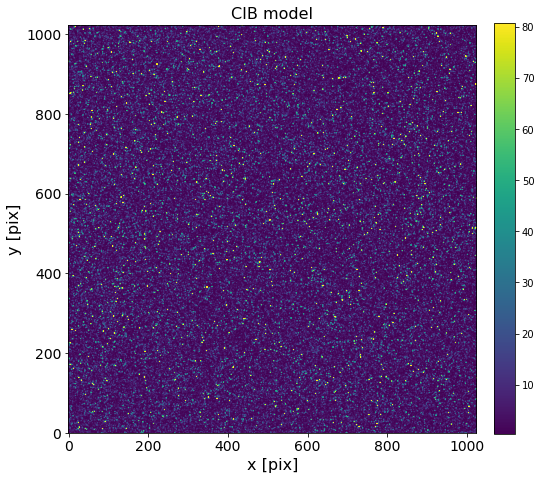

min max of image in plot map are  4.688216441925994 11.16446709464819


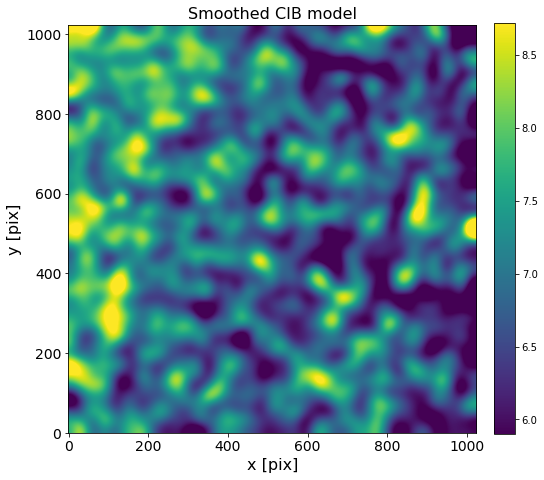

In [13]:
plot_map(full_maps[0], title='CIB model')
plot_map(gaussian_filter(full_maps[0], sigma=20), title='Smoothed CIB model')

Next, we can generate realizations of stellar light using the empirical TRILEGAL model. The function `make_synthetic_trilegal_cat()` takes the synthetic stellar catalog specific to each science field and draws positions for those stars randomly (under assumption stars have no large-scale clustering on degree scales). Each catalog realization has the same set of magnitudes from the original synthetic catalog. In certain cases where the brightest star in each observed field is known, one can make cuts on the TRILEGAL catalog to reflect this prior knowledge. 

In [5]:
dimx, dimy = 1024, 1024
cmock = ciber_mock(ciberdir='/Users/luminatech/Documents/ciber2/ciber/', pcat_model_eval=False)
ifield_list = [4, 5, 6, 7, 8]

# useful for when brightest stars in observed fields are known 
m_min_perfield = dict({4: 5.69, 5: 4.52, 6: 7.82, 7:7.20, 8:6.63})
m_max = 28.0
m_tracer_max = 19.

datestr = '100921'
data_path= '/Volumes/Seagate Backup Plus Drive/Toolkit/Mirror/Richard/ciber_mocks/'+datestr+'/trilegal/'

nsims = 1

for simidx in range(nsims):
    
    full_maps_J, full_maps_H, cats = [], [], []
    
    for i, ifield in enumerate(ifield_list):
        
        field_name = cmock.ciber_field_dict[ifield]
        print('field name is ', field_name)
        trilegal_path = 'data/mock_trilegal_realizations_051321/trilegal_'+field_name+'.dat'

        # This function uses the same magnitudes but draws random uniform positions, which is a good approximation for stars in CIBER field of view
        gen_trilegal_cat = make_synthetic_trilegal_cat(trilegal_path, I_band_idx=26, H_band_idx=27)
        filt_x = filter_trilegal_cat(gen_trilegal_cat, I_band_idx=2, m_min=m_min_perfield[ifield], m_max=m_max)
    
        # convert catalog magnitudes to nu*I_nu
        star_Iarr_full_I = cmock.mag_2_nu_Inu(filt_x[:,2], band=0)
        star_Iarr_full_H = cmock.mag_2_nu_Inu(filt_x[:,3], band=1)
        cat_full = np.hstack([filt_x, np.expand_dims(star_Iarr_full_I.value, axis=1), np.expand_dims(star_Iarr_full_H.value, axis=1)])

        # use full catalog to generate model image. 
        # Because the CIBER PSF is undersampled we query an interpolated PSF depending on the subpixel each catalog source falls in. 
        srcmap_stars_J = cmock.make_srcmap_temp_bank(ifield, 1, cat_full, flux_idx=4, n_fine_bin=10, nwide=17)
        srcmap_stars_H = cmock.make_srcmap_temp_bank(ifield, 2, cat_full, flux_idx=5, n_fine_bin=10, nwide=17)

        full_maps_J.append(srcmap_stars_J)
        full_maps_H.append(srcmap_stars_H)
        
        # save tracer catalog for masking
        cat_tracer = filter_trilegal_cat(cat_full, I_band_idx=2, m_max=m_tracer_max)
        print('cat tracer has shape ', cat_tracer.shape)
        cats.append(cat_tracer)
    
    # column names for stellar catalog
    names = ['x', 'y', 'j_m', 'h_m', 'j_nuInu', 'h_nuInu']
    
    tail_name = 'mock_trilegal_simidx'+str(simidx)+'_'+datestr
    # save mocks to file
    
#     save_mock_to_fits(full_maps_J, cats, tail_name, names=names, full_maps_band2=full_maps_H, data_path=data_path, m_tracer_max=m_tracer_max, m_min=m_min_perfield[ifield], m_max=m_max,\
#                       ifield_list=ifield_list, map_names=['trilegal_J', 'trilegal_H'])
        
        

field name is  elat10
synthetic cat has shape  (53251, 4)
cat tracer has shape  (6835, 6)
field name is  elat30
synthetic cat has shape  (41824, 4)
cat tracer has shape  (5776, 6)
field name is  BootesB
synthetic cat has shape  (59650, 4)
cat tracer has shape  (7366, 6)
field name is  BootesA
synthetic cat has shape  (60016, 4)
cat tracer has shape  (7553, 6)
field name is  SWIRE
synthetic cat has shape  (88587, 4)
cat tracer has shape  (11273, 6)


How do TRILEGAL images look? We can zoom in on specific regions with `plot_map()`.

min max of image in plot map are  0.0001413762931185284 8050230.488639444


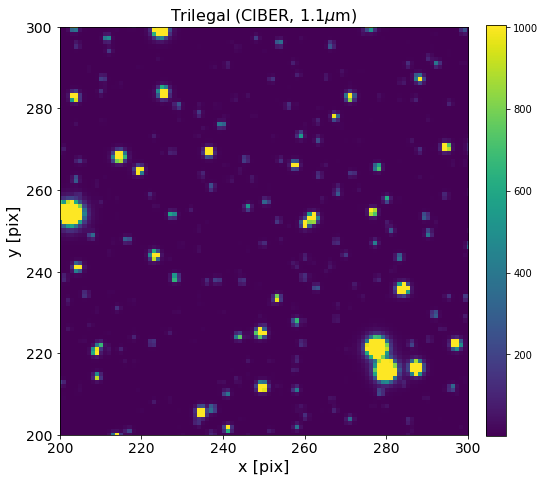

min max of image in plot map are  8.798401024816446e-05 6530471.949497216


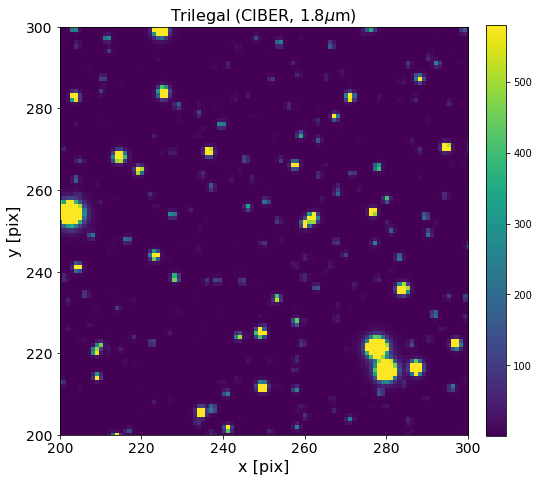

In [7]:
plot_map(srcmap_stars_J, title='Trilegal (CIBER, 1.1$\\mu$m)', x0=200, x1=300, y0=200, y1=300)
plot_map(srcmap_stars_H, title='Trilegal (CIBER, 1.8$\\mu$m)', x0=200, x1=300, y0=200, y1=300

At this point we have included astrophysical signal related to the stars and galaxies in our fields. Next we can generate diffuse realizations from relevant foregrounds. In CIBER we want to model diffuse galactic light (DGL), 
which we do by generating gaussian random fields with a power spectrum defined by 1) the large-scale C_ell amplitude and 2) the power law slope of the diffuse signal power spectrum. This information goes into the function `generate_diffuse_realization()`. 
The current implementation is a bit ad hoc, but one could modify generate_diffuse_realization() to feed in a desired 1D or 2D power spectrum. 


min max of image in plot map are  -5.473086011472253 5.590213499671415


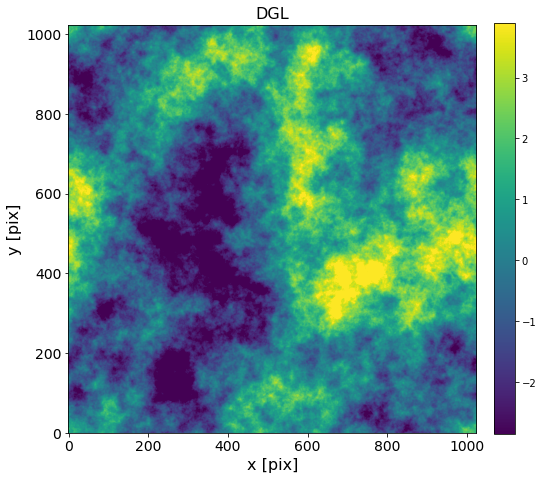

In [14]:
nsims = 1
inst = 1
dimx, dimy = 1024, 1024
ifield_list = [4, 5, 6, 7, 8]

# specify power law index of diffuse component power spectrum
power_law_idx = -3.0

cl_pivot_facs = [420.6, 149.0, 318.5, 772.8, 194.6] # hard coded these in here for convenience, usually grab them from DGL files

for simidx in range(nsims):
    
    for i, ifield in enumerate(ifield_list):

        if cl_pivot_facs is None:
            # calculate amplitude of large-scale power spectrum for DGL
            field_name = cmock.ciber_field_dict[ifield]
            cl_dgl_iras = np.load('data/fluctuation_data/TM'+str(inst)+'/dgl_sim/dgl_from_iris_model_TM'+str(inst)+'_'+field_name+'.npz')['cl']
            cl_pivot_fac = cl_dgl_iras[0]*dimx*dimy
        else:
            cl_pivot_fac = cl_pivot_facs[i]
        
        # generate gaussian random field realization with desired power spectrum
        _, _, diff_realization = generate_diffuse_realization(dimx, dimy, power_law_idx=power_law_idx, scale_fac=cl_pivot_fac)

        # check to see how the diffuse realization looks
        if i==0:
            plot_map(diff_realization, title='DGL')



Lastly we want to generate the observation mask, which is a combination of an instrument/bad pixel mask and an astronomical source mask. 

In [ ]:

# inst = 2
# generate_starmask = True
# generate_galmask = True
# save_Mkk = True
# save_mask = True
# n_mkk_sims = 50
# datestr = '100921'

# mag_lim_AB = 17.5

# base_path = '/Volumes/Seagate Backup Plus Drive/Toolkit/Mirror/Richard/ciber_mocks/'+datestr+'/'
# ifield_list = np.arange(4, 9)

# simidx_range = np.arange(10)

# for sim_idx in simidx_range:
#     joint_masks = []

#     for i, ifield in enumerate(ifield_list):

#         print(i, ifield)

#         joint_mask = np.ones((dimx, dimy))
#         field_name = cmock.ciber_field_dict[ifield]
        
#         # load mock TRILEGAL catalog and map
#         mock_trilegal_path = base_path+'trilegal/mock_trilegal_simidx'+str(sim_idx)+'_'+datestr+'.fits'
#         mock_trilegal = fits.open(mock_trilegal_path)
#         mock_trilegal_cat = mock_trilegal['tracer_cat_'+str(ifield)].data
#         mock_trilegal_map = mock_trilegal['trilegal_'+str(cbps.inst_to_band[inst])+'_'+str(ifield)].data
        
#         plot_map(mock_trilegal_map.transpose(), title='mock trilegal map')

#         print('mock trilegal cat has shape ', mock_trilegal_cat.shape)

#         # load mock galaxy catalog and map
#         mock_gal = fits.open(base_path+'TM'+str(inst)+'/cib_with_tracer_5field_set'+str(sim_idx)+'_'+datestr+'_TM'+str(inst)+'.fits')
#         mock_gal_cat = mock_gal['tracer_cat_'+str(ifield)].data
#         mock_gal_map = mock_gal['map'+str(ifield)].data
#         print('mock_gal cat has shape ', mock_gal_cat.shape)
#         print(mock_gal_cat.names)

#         if inst==1:
#             magkey = 'j_m'
#         else:
#             magkey = 'h_m'

#         # use catalog to generate mask, using prescription in get_masks(). This has been optimized for CIBER observations
#         if generate_starmask:
#             star_cat = {magkey:mock_trilegal_cat[magkey].byteswap().newbyteorder(), 'x'+str(inst):mock_trilegal_cat['x'].byteswap().newbyteorder(), 'y'+str(inst):mock_trilegal_cat['y'].byteswap().newbyteorder()}
#             star_cat_df = pd.DataFrame(star_cat)
#             star_cat_df.columns = [magkey, 'x'+str(inst), 'y'+str(inst)]
#             starmask, radii_stars_simon, radii_stars_Z14 = get_masks(star_cat_df, param_combo, intercept_mag, mag_lim_AB, magstr=magkey, inst=inst, dimx=cbps.dimx, dimy=cbps.dimy, verbose=True)
#             joint_mask *= starmask

#             plot_map(starmask, title='starmask')
#             plot_map(mock_trilegal_map.transpose()*starmask, title='trilegal x starmask')

#         # use galaxy catalog to generate galaxy source mask.
#         if generate_galmask:
#             midxdict = dict({'x':0, 'y':1, 'redshift':2, 'm_app':3, 'M_abs':4, 'Mh':5, 'Rvir':6})
#             gal_cat = {magkey:mock_gal_cat['m_app'].byteswap().newbyteorder(), 'x'+str(inst):mock_gal_cat['x'].byteswap().newbyteorder(), 'y'+str(inst):mock_gal_cat['y'].byteswap().newbyteorder()}
#             gal_cat_df = pd.DataFrame(gal_cat, columns = ['m_app', 'x'+str(inst), 'y'+str(inst)]) # check magnitude system of Helgason model
#             galmask, radii_stars_simon, radii_stars_Z14 = get_masks(gal_cat_df, param_combo, intercept_mag, mag_lim_AB, magstr='m_app', inst=inst, dimx=cbps.dimx, dimy=cbps.dimy, verbose=True)
#             joint_mask *= galmask

#         # how does full mask look?
#         plot_map(joint_mask, title='joint mask')

#         joint_masks.append(joint_mask)


#     for i, ifield in enumerate(ifield_list):
        
#         # write mask file and save
#         if save_mask:
#             hdul = write_mask_file(np.array(joint_masks[i]), ifield=ifield, inst=inst, sim_idx=sim_idx, generate_galmask=generate_galmask, \
#                                   generate_starmask=generate_starmask, use_inst_mask=use_inst_mask, dat_type=dat_type, mag_lim_AB=mag_lim_AB)

#             hdul.writeto(base_path+'TM'+str(inst)+'/masks/joint_mask_ifield'+str(ifield)+'_inst'+str(inst)+'_simidx'+str(sim_idx)+'_abc110821.fits', overwrite=True)

#         # if desired bandpowers known already, can estimate mode coupling matrices induced by masks and save those as well.
#         if save_Mkk:
                        
#             Mkk = cbps.Mkk_obj.get_mkk_sim(joint_masks[i], n_mkk_sims, n_max_persplit=50, store_Mkks=False)
#             inv_Mkk = compute_inverse_mkk(Mkk)
#             plot_mkk_matrix(inv_Mkk, inverse=True, symlogscale=True)
            
#             hdul = write_Mkk_fits(Mkk, inv_Mkk, ifield, inst, sim_idx=sim_idx, generate_starmask=generate_starmask, generate_galmask=generate_galmask, \
#                                  use_inst_mask=use_inst_mask, dat_type=dat_type, mag_lim_AB=mag_lim_AB)

#             hdul.writeto(base_path+'TM'+str(inst)+'/mkk/mkk_estimate_ifield'+str(ifield)+'_inst'+str(inst)+'_simidx'+str(sim_idx)+'_abc110821.fits', overwrite=True)





        